# Importing Module and define directories

In [64]:
%matplotlib inline
project_dir = '../../'
data_dir = project_dir + 'data/'

import sys
sys.path.append(project_dir + 'NN/')

import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
import MLP
import layer
importlib.reload(MLP)
importlib.reload(layer)
from MLP import MLP, MLP_w
from utils.preprocessing import split,StandardScaler, MinMaxScaler

from utils.regressor import regressor
from utils.trick_output import lin_sin_lin, trick_params
import ensemble
importlib.reload(ensemble)
from ensemble import bagging_ensemble
import utils.results
importlib.reload(utils.results)
from utils.results import plot_results, output_correlations


# Train - Validation Split

In [17]:
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]
data = raw_data[:,:10] ; labels = raw_data[:,-2:]
norm_data = MinMaxScaler()
norm_labels = MinMaxScaler()
data = norm_data.fit_transform(data)
labels = norm_labels.fit_transform(labels)
all_norm_data = np.column_stack((data, labels))

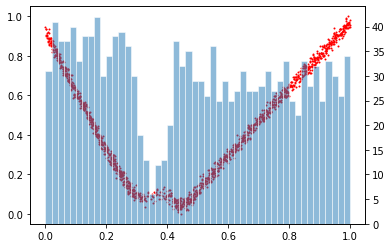

In [18]:
hard_out = labels[:, 1]
easy_out = labels[:, 0]

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.scatter(hard_out, easy_out, s = 1, c='red')
ax_right.hist(hard_out, bins = 50, alpha = 0.5, ec="white")
plt.show()

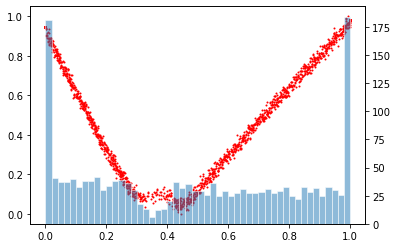

In [19]:
def generate_in_middle(dataset, d1, d2):
    mid = (dataset[d1, :] + dataset[d2, :])/2
    return np.row_stack((dataset, mid))

def expand_in_middle(n_new_data, dataset, lim_inf, lim_sup, unbal_feature):
    data_copy = np.copy(dataset)
    mask_inf = data_copy[:, unbal_feature] > lim_inf
    mask_sup = data_copy[:, unbal_feature] < lim_sup
    mid_data = data_copy[np.logical_and(mask_inf, mask_sup)]
    rng = np.random.default_rng()
    for i in range(n_new_data):
        val = rng.normal(loc = (lim_inf + lim_sup)/2, 
                         scale = np.abs((lim_inf - lim_sup)/2))
        sort_for_val = np.argsort(np.abs(data_copy[:,unbal_feature]-val))
        d1 = sort_for_val[0]
        d2 = sort_for_val[1]
        data_copy = generate_in_middle(data_copy, d1, d2)
    return data_copy

new_dataset = expand_in_middle(150, all_norm_data, 1.3, 1.7, 11)
new_dataset = expand_in_middle(150, new_dataset, -1.6, -1.4, 11)

hard_out = new_dataset[:, 11]
easy_out = new_dataset[:, 10]

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.scatter(hard_out, easy_out, s = 1, c='red')
ax_right.hist(hard_out, bins = 50, alpha = 0.5, ec="white")
plt.show()

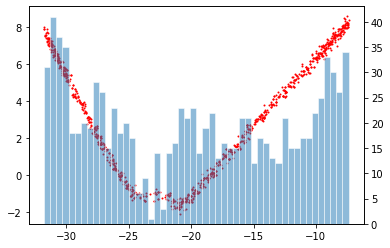

In [20]:
def generate_in_middle(dataset, d1, d2):
    mid = (dataset[d1, :] + dataset[d2, :])/2
    return np.row_stack((dataset, mid))

def remove_in_middle(n, dataset, lim_inf, lim_sup, unbal_feature):
    data_copy = np.copy(dataset)
    mask_inf = data_copy[:, unbal_feature] > lim_inf
    mask_sup = data_copy[:, unbal_feature] < lim_sup
    left_data = data_copy[data_copy[:, unbal_feature] < lim_inf]
    mid_data = data_copy[np.logical_and(mask_inf, mask_sup)]
    right_data = data_copy[data_copy[:, unbal_feature] > lim_sup]
    rng = np.random.default_rng()
    mid_data = rng.choice(mid_data, size = len(mid_data) - n )
    data_copy = np.row_stack((left_data, mid_data))
    data_copy = np.row_stack((data_copy, right_data))
    return data_copy

new_dataset = remove_in_middle(500, raw_data, -30, -10, 11)

hard_out = new_dataset[:, 11]
easy_out = new_dataset[:, 10]

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.scatter(hard_out, easy_out, s = 1, c='red')
ax_right.hist(hard_out, bins = 50, alpha = 0.5, ec="white")
plt.show()

In [21]:
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]
data = raw_data[:,:10] ; labels = raw_data[:,-2:]
norm_data = StandardScaler()
norm_labels = StandardScaler()
data = norm_data.fit_transform(data)
labels = norm_labels.fit_transform(labels)

frac_test=0.1
data, test_set, labels, test_labels = split(data, labels, 
                                            kind="hold_out",frac_training=1-frac_test)

In [22]:
#xavier weight inizialization
def xavier(structure):
    start=np.zeros(len(structure))
    for idx,num in enumerate(structure):
        if idx==0:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx])
        else:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx-1]+structure[idx])
    return list(start)


# Define the MLP

## Train the model

In [29]:
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]
data = raw_data[:,:10] ; labels = raw_data[:,-2:]
norm_data = StandardScaler()
norm_labels = StandardScaler()
data = norm_data.fit_transform(data)
labels = norm_labels.fit_transform(labels)

frac_test=0.1
data, test_set, labels, test_labels = split(data, labels, 
                                            kind="hold_out",frac_training=1-frac_test)

frac_training=0.8
input_data, val_data, train_labels, val_labels=split(data, labels,kind="hold_out",
                                                     frac_training=frac_training)


train_labels1 = train_labels[:,1].reshape((len(train_labels),1))
val_labels1 = val_labels[:,1].reshape((len(val_labels), 1))

In [52]:
other_output= train_labels[:,0]
lin_output= train_labels[:,1]

x = np.copy(lin_output)
y = np.copy(other_output)

used_data = np.column_stack((input_data, train_labels))

xx = np.linspace(np.min(x), np.max(x), 1000)
params = trick_params(norm_name = 'vecstd')

reg = regressor()
reg.fit(x, y, lin_sin_lin, params)
popt_sin = reg.best_params

# fig, axs = plt.subplots(1, 2, figsize = (10, 3))
# axs[0].plot(xx,lin_sin_lin(xx,*popt_sin))
# axs[0].scatter(x, y, s = 5, label ='real', alpha = 0.3, c='orange')
# axs[0].set_title('fit func vs data')
# axs[1].scatter(x, y-lin_sin_lin(x,*popt_sin), s = 5)
# axs[1].set_title('residual')
# plt.show()
# RMS = np.sqrt(np.sum((y-lin_sin_lin(x,*popt_sin))**2))
# print(f'RMS = {RMS} (root sum of squared residual)')

reg.reason

'kmax iteration reached'

In [31]:
structure=[10,5, 2]
act_func=[("tanh",1)]*(len(structure)-1) + [("linear",1)]
start=xavier(structure)

N_epoch = 50000
lamb=1e-6; batch_size = -1; alpha=0.5 ; nesterov=True ; eta_function=1e-4
beta=0.9
netw = MLP(structure, func=act_func,starting_points=start)

In [ ]:
netw.train(input_data, train_labels , val_data, val_labels,
           epoch = N_epoch,
           batch_size=batch_size,
           eta = eta_function, lamb = lamb,alpha=alpha,
           nesterov=nesterov,RMSProp=True,beta=beta,
           patience = 100, error_threshold = 0.)

# Plot results

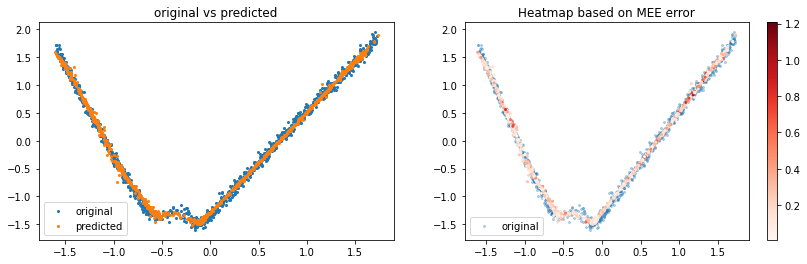

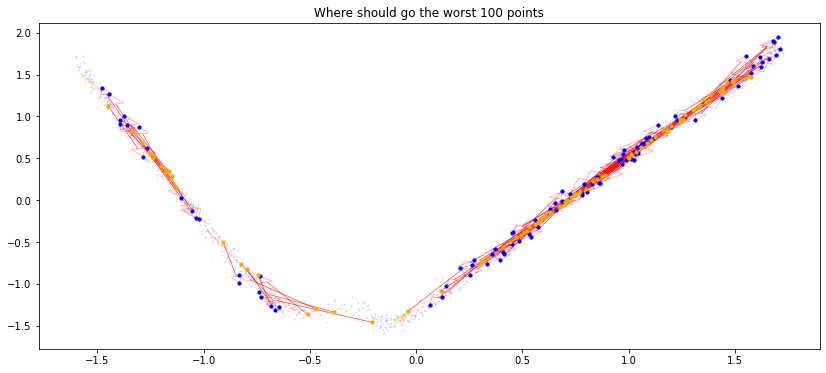

In [33]:
import utils.results
importlib.reload(utils.results)
from utils.results import plot_results, output_correlations

w = output_correlations(netw, input_data, train_labels, plot_arrow_worse = 100,
                    fit_func = lin_sin_lin, func_args = popt_sin
                   )

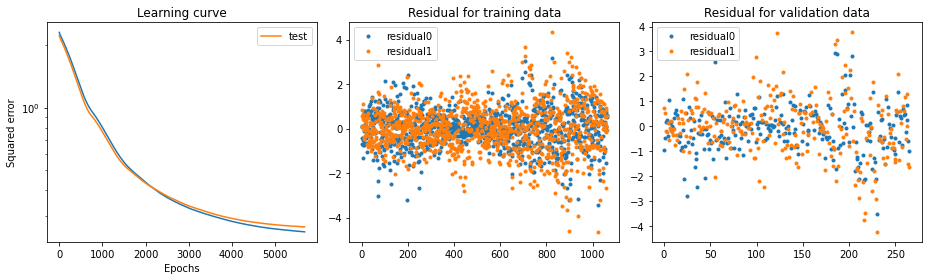

final train error: 1.0748655036493868
final val error: 1.1313970557739559


In [28]:
plot_results(netw, input_data, val_data, train_labels, val_labels, 
             func = lin_sin_lin, func_args = popt_sin, mean_fit = True,
             norm = norm_labels.inverse_transform,
             sortidx = 1)

## Try an ensemble

In [8]:
import ensemble
importlib.reload(ensemble)
from ensemble import bagging_ensemble

In [39]:
norm_data = StandardScaler()
norm_labels = StandardScaler(kind="vector")
data = norm_data.fit_transform(data)
labels = norm_labels.fit_transform(labels)

In [45]:
raw_data=np.loadtxt("../../data/Data_set.txt")
data = raw_data[:,:10] ; labels = raw_data[:,-2:]
norm_data = StandardScaler()
norm_labels = StandardScaler(kind="vector")
data = norm_data.fit_transform(data)
labels = norm_labels.fit_transform(labels)

frac_training=0.8
input_data, val_data, train_labels, val_labels=split(data, labels,kind="hold_out",
                                                        frac_training=frac_training)

#xavier weight inizialization
def xavier(structure):
    start=np.zeros(len(structure))
    for idx,num in enumerate(structure):
        if idx==0:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx])
        else:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx-1]+structure[idx])
    return list(start)

In [19]:
bagg = bagging_ensemble(10)

dict_MLP = {'structure':[10,5, labels.shape[-1]],
            'func':["tanh","relu","linear"],
            'starting_points':xavier([10,5,2])}

dict_train = {'epoch':10000,
                'batch_size':-1,
                'eta':5e-4,
                'lamb':1e-6,
                'alpha':0.2,
                'nesterov':True,
                'RMSProp':True,
                'beta':0.8,
                'error_threshold':0.,
                'patience':200,
                'verbose':True,
                'n_candidate':5,
                'test_more_init':True}

bagg.train(input_data, train_labels , val_data, val_labels,MLP_w, dict_MLP, dict_train, bootstrap = False)

0/10
Candidate 0
Epoch 1548:  [train MEE = 0.1586]  [val MEE = 0.1782]                              
Elapsed time: 4.206192493438721 s
Candidate 1
Epoch 1992:  [train MEE = 0.1480]  [val MEE = 0.1666]                              
Elapsed time: 5.372567653656006 s
Candidate 2
Epoch 1745:  [train MEE = 0.1560]  [val MEE = 0.1708]                              
Elapsed time: 4.762772083282471 s
Candidate 3
Epoch 4281:  [train MEE = 0.1374]  [val MEE = 0.1555]                              
Elapsed time: 11.549308776855469 s
Candidate 4
Epoch 2383:  [train MEE = 0.1427]  [val MEE = 0.1601]                              
Elapsed time: 6.470111608505249 s
1/10
Candidate 0
Epoch 3223:  [train MEE = 0.1437]  [val MEE = 0.1659]                              
Elapsed time: 8.735957622528076 s
Candidate 1
Epoch 2992:  [train MEE = 0.1465]  [val MEE = 0.1692]                              
Elapsed time: 8.159048795700073 s
Candidate 2
Epoch 2051:  [train MEE = 0.1401]  [val MEE = 0.1588]              

In [22]:
dict_MLP = {'structure':[10,20, labels.shape[-1]],
            'func':["tanh","tanh","linear"],
            'starting_points':xavier([10,20,2])}

dict_train = {'epoch':10000,
                'batch_size':-1,
                'eta':5e-4,
                'lamb':1e-5,
                'alpha':0.2,
                'nesterov':True,
                'RMSProp':True,
                'beta':0.75,
                'error_threshold':0.,
                'patience':300,
                'verbose':True,
                'n_candidate':5,
                'test_more_init':True}

bagg.train(input_data, train_labels , val_data, val_labels,
            MLP_w, dict_MLP, dict_train, bootstrap = False)

10/20
Candidate 0
Epoch 2384:  [train MEE = 0.1365]  [val MEE = 0.1587]                              
Elapsed time: 10.497674226760864 s
Candidate 1
Epoch 1444:  [train MEE = 0.1435]  [val MEE = 0.1594]                              
Elapsed time: 6.342398405075073 s
Candidate 2
Epoch 1793:  [train MEE = 0.1447]  [val MEE = 0.1607]                              
Elapsed time: 7.760070562362671 s
Candidate 3
Epoch 1515:  [train MEE = 0.1413]  [val MEE = 0.1608]                              
Elapsed time: 6.599015712738037 s
Candidate 4
Epoch 2299:  [train MEE = 0.1378]  [val MEE = 0.1591]                              
Elapsed time: 10.033515214920044 s
11/20
Candidate 0
Epoch 1238:  [train MEE = 0.1489]  [val MEE = 0.1674]                              
Elapsed time: 5.335905075073242 s
Candidate 1
Epoch 1628:  [train MEE = 0.1425]  [val MEE = 0.1564]                              
Elapsed time: 7.144468784332275 s
Candidate 2
Epoch 1675:  [train MEE = 0.1440]  [val MEE = 0.1640]           

In [23]:
dict_MLP = {'structure':[10,10, labels.shape[-1]],
            'func':["tanh","tanh","linear"],
            'starting_points':xavier([10,10,2])}

dict_train = {'epoch':10000,
                'batch_size':-1,
                'eta':5e-4,
                'lamb':1e-7,
                'alpha':0.2,
                'nesterov':True,
                'RMSProp':True,
                'beta':0.8,
                'error_threshold':0.,
                'patience':300,
                'verbose':True,
                'n_candidate':5,
                'test_more_init':True}

bagg.train(input_data, train_labels , val_data, val_labels,
            MLP_w, dict_MLP, dict_train, bootstrap = False)

20/30
Candidate 0
Epoch 1868:  [train MEE = 0.1430]  [val MEE = 0.1637]                              
Elapsed time: 6.351991653442383 s
Candidate 1
Epoch 1873:  [train MEE = 0.1401]  [val MEE = 0.1584]                              
Elapsed time: 6.294069051742554 s
Candidate 2
Epoch 4139:  [train MEE = 0.1316]  [val MEE = 0.1472]                              
Elapsed time: 13.8706693649292 s
Candidate 3
Epoch 2869:  [train MEE = 0.1385]  [val MEE = 0.1606]                              
Elapsed time: 9.525434970855713 s
Candidate 4
Epoch 2666:  [train MEE = 0.1374]  [val MEE = 0.1594]                              
Elapsed time: 8.873815059661865 s
21/30
Candidate 0
Epoch 1798:  [train MEE = 0.1440]  [val MEE = 0.1569]                              
Elapsed time: 5.9150331020355225 s
Candidate 1
Epoch 2119:  [train MEE = 0.1387]  [val MEE = 0.1581]                              
Elapsed time: 6.9947123527526855 s
Candidate 2
Epoch 2013:  [train MEE = 0.1424]  [val MEE = 0.1622]            

In [24]:
dict_MLP = {'structure':[10,10,10, labels.shape[-1]],
            'func':["tanh","tanh","tanh","linear"],
            'starting_points':xavier([10,10,10,2])}

dict_train = {'epoch':10000,
                'batch_size':-1,
                'eta':5e-4,
                'lamb':1e-6,
                'alpha':0.2,
                'nesterov':True,
                'RMSProp':True,
                'beta':0.75,
                'error_threshold':0.,
                'patience':300,
                'verbose':True,
                'n_candidate':5,
                'test_more_init':True}

bagg.train(input_data, train_labels , val_data, val_labels,
            MLP_w, dict_MLP, dict_train, bootstrap = False)

30/40
Candidate 0
Epoch 1493:  [train MEE = 0.1454]  [val MEE = 0.1618]                              
Elapsed time: 6.905295372009277 s
Candidate 1
Epoch 2723:  [train MEE = 0.1362]  [val MEE = 0.1569]                              
Elapsed time: 12.523120164871216 s
Candidate 2
Epoch 1749:  [train MEE = 0.1421]  [val MEE = 0.1591]                              
Elapsed time: 8.06401014328003 s
Candidate 3
Epoch 2789:  [train MEE = 0.1369]  [val MEE = 0.1671]                              
Elapsed time: 12.851391792297363 s
Candidate 4
Epoch 1602:  [train MEE = 0.1475]  [val MEE = 0.1729]                              
Elapsed time: 7.384999513626099 s
31/40
Candidate 0
Epoch 1523:  [train MEE = 0.1429]  [val MEE = 0.1518]                              
Elapsed time: 7.001574277877808 s
Candidate 1
Epoch 1836:  [train MEE = 0.1416]  [val MEE = 0.1628]                              
Elapsed time: 8.387225151062012 s
Candidate 2
Epoch 1839:  [train MEE = 0.1419]  [val MEE = 0.1598]            

In [26]:
bagg.prune_ensemble

Pruned 2/40 classifier


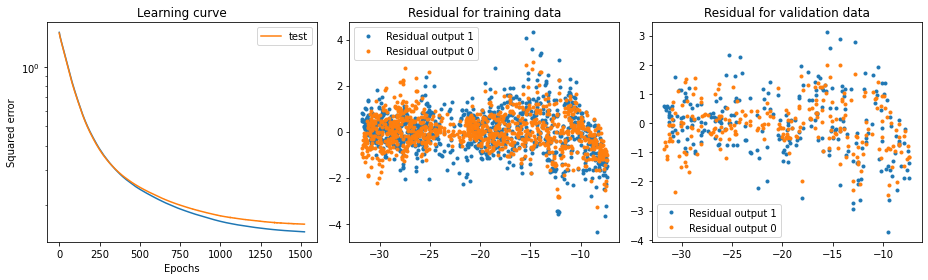

final train error: 0.9549528040044538
final val error: 1.0822305552289566


In [70]:
import utils.results
importlib.reload(utils.results)
from utils.results import plot_results, output_correlations

plot_results(bagg, input_data, val_data, train_labels, val_labels,
             func = lin_sin_lin, func_args = popt_sin, mean_fit = True, 
             norm = norm_labels.inverse_transform, 
             sortidx = True)

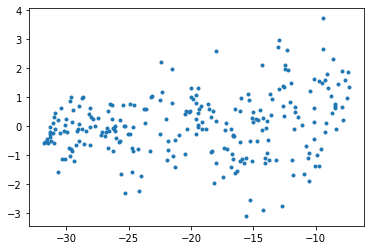

In [66]:
bag_pred_val=norm_labels.inverse_transform(bagg.predict(val_data))
new_val=norm_labels.inverse_transform(val_labels)
plt.plot(np.sort(new_val[:,1]),new_val[:,1][np.argsort(new_val[:,1])]-bag_pred_val[:,1][np.argsort(new_val[:,1])], '.')

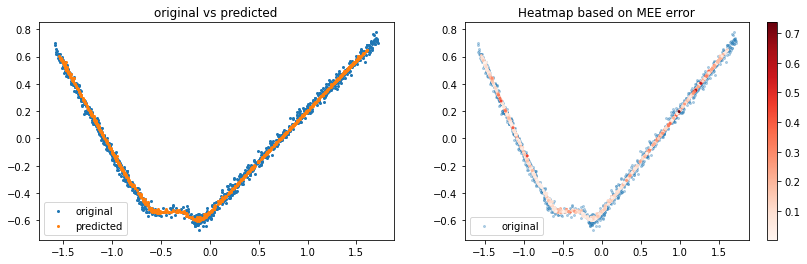

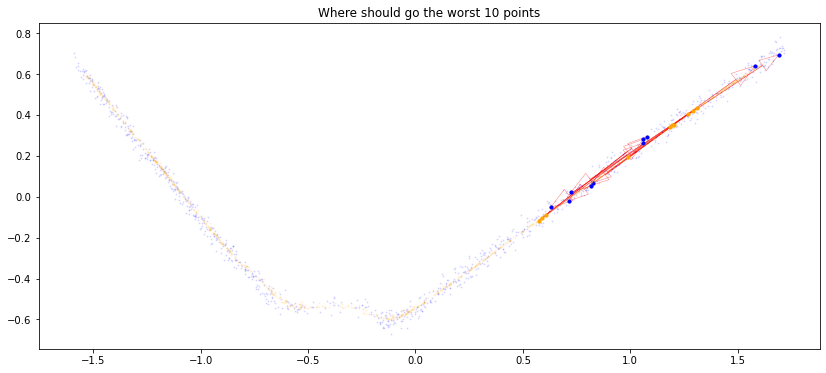

[844 917  67 857 118   8 755 623 557 722]


In [55]:
w_worst = output_correlations(bagg, input_data, train_labels, plot_arrow_worse = 10,
                    fit_func = lin_sin_lin, func_args = popt_sin
                   )

print(w_worst)

In [38]:
structure=[10,5, 2]
act_func=[("tanh",1)]*(len(structure)-1) + [("linear",1)]
start=xavier(structure)

N_epoch = 500
lamb=1e-6; batch_size = -1; alpha=0.1 ; nesterov=True ; eta_function=5e-3
beta=0.5
worst_nt = MLP(structure, func=act_func,starting_points=start)

In [39]:
worst_nt.train(input_data[w_worst], train_labels[w_worst] , val_data, val_labels,
           epoch = N_epoch,
           batch_size=batch_size,
           eta = eta_function, lamb = lamb,alpha=alpha,
           nesterov=nesterov,RMSProp=True,beta=beta,
           patience = -1, error_threshold = 0 )

Epoch 500:  [train MEE = 0.0342]  [val MEE = 1.6081]                              
Elapsed time: 0.2645752429962158 s


In [36]:
raw_test=np.loadtxt("../../data/Test_set.txt")
test_data = raw_test[:,:10] ; test_labels = raw_test[:,-2:]
test_data = norm_data.transform(test_data)
test_labels = norm_labels.transform(test_labels)